Epoch 1/100


C:\Users\rmarc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2605/2605 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0045 - val_loss: 0.0032
Epoch 2/100
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 3/100
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0015 - val_loss: 4.3733e-04
Epoch 4/100
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 9.4687e-04 - val_loss: 8.1245e-05
Epoch 5/100
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0011 - val_loss: 2.6922e-04
Epoch 6/100
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0012 - val_loss: 6.0616e-05
Epoch 7/100
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 8.0895e-04 - val_loss: 1.3747e-04
Epoch 8/100
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 9.8103e-04 - val_loss: 5.6263e-05
Epoch 9/100
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 8.6686e-04 - val_loss: 3.9166e-05
Epoch 10/100
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 8.1379e-04 - val_loss: 3.6096e-05
Epoch 11/100
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 7.322

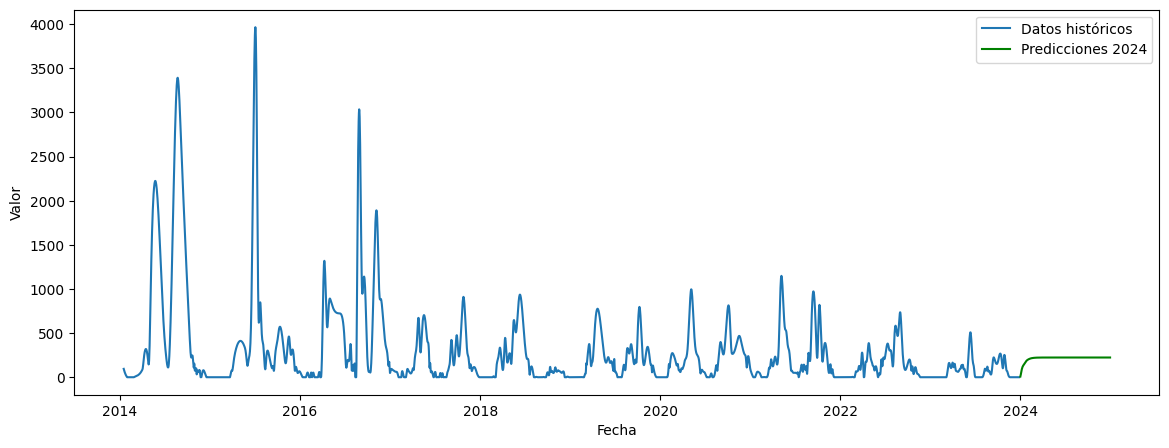

Predicciones para 2024 guardadas en predictions_2024.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Leer los datos
data = pd.read_csv('../data/processed/medias3.csv')
df = pd.DataFrame(data)
df['fecha'] = pd.to_datetime(df['fecha'])

# Ordenar los datos por fecha
df.sort_values('fecha', inplace=True)

# Dividir en conjunto de entrenamiento y prueba
train_df = df[((df['fecha'] >= '2014-01-01') & (df['fecha'] <= '2014-12-31')) | ((df['fecha'] >= '2016-01-01') & (df['fecha'] <= '2023-12-31'))]
test_df = df[(df['fecha'] >= '2015-01-01') & (df['fecha'] <= '2015-12-31')]

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_df['ao'].values.reshape(-1, 1))
scaled_test_data = scaler.transform(test_df['ao'].values.reshape(-1, 1))

# Función para crear dataset con time steps
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Definir el paso de tiempo (lookback)
time_step = 10
X_train, y_train = create_dataset(scaled_train_data, time_step)
X_test, y_test = create_dataset(scaled_test_data, time_step)

# Redimensionar los datos para que sean compatibles con LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Construir el modelo LSTM con Dropout
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Implementar Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo solo con los datos de entrenamiento
history = model.fit(X_train, y_train, batch_size=1, epochs=100, validation_split=0.2, callbacks=[early_stop])

# Hacer predicciones con los datos de prueba
test_predict = model.predict(X_test)

# Desnormalizar las predicciones y los valores reales
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Crear un DataFrame con las predicciones y las fechas correspondientes
test_predictions = pd.DataFrame(test_predict, columns=['Predicted'], index=test_df.index[-len(test_predict):])
test_predictions['Fecha'] = test_df['fecha'].values[-len(test_predict):]

# Crear una nueva secuencia para predecir el 2024
last_sequence = scaled_train_data[-time_step:]  # Última secuencia del conjunto de entrenamiento

# Almacenar predicciones para 2024
future_predictions_scaled = []

for _ in range(365):  # Por ejemplo, para predecir 365 días
    next_pred_scaled = model.predict(last_sequence.reshape(1, time_step, 1))
    future_predictions_scaled.append(next_pred_scaled[0, 0])
    last_sequence = np.append(last_sequence[1:], next_pred_scaled)

# Transformar las predicciones de vuelta a su escala original
future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

# Crear fechas para el 2024
future_dates = pd.date_range(start='2024-01-01', periods=365, freq='D')

# Crear un DataFrame con las predicciones futuras
future_df = pd.DataFrame(future_predictions, columns=['Predicted'], index=future_dates)

# Graficar las predicciones futuras
plt.figure(figsize=(14,5))
plt.plot(df['fecha'], df['ao'], label='Datos históricos')
plt.plot(future_df.index, future_df['Predicted'], color='green', label='Predicciones 2024')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

# Guardar las predicciones en un archivo CSV
future_df.to_csv('predictions_2024.csv', index=True)
print("Predicciones para 2024 guardadas en predictions_2024.csv")
